In [97]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

import warnings


In [98]:
# Ignore all warnings that may occur during the execution of the code
warnings.filterwarnings('ignore')

### Load Dataset

In [99]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

In [100]:
# metadata 
print(adult.metadata) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [101]:
# variable information 
print(adult.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

In [102]:
# Convert to Pandas Data Frame
df = pd.DataFrame(data=X, columns=adult.feature_names)
# Adding the 'income' column to the Data Frame
df['income'] = y 

In [103]:
# View the first few rows of the Data Frame
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Clean Dataset

In [104]:
#  Shape of the Data Frame
df.shape  # first element represents the number of rows and the second element represents the number of columns

(48842, 15)

In [105]:
# Count of missing values (NaN) for each column in the Data Frame 
df.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [106]:
# Get the data types of each column in the Data Frame
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [107]:
# Number of unique values for each column in the Data Frame 
df.nunique()  # To understand the cardinality of values in each column

age                  74
workclass             9
fnlwgt            28523
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        123
capital-loss         99
hours-per-week       96
native-country       42
income                4
dtype: int64

In [108]:
# Understanding the distribution of different categories within a categorical column
# Count of each unique value in the 'occupation' column of the Data Frame 
df['occupation'].value_counts()

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
?                    1843
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

In [109]:
df['workclass'].value_counts()  # Count of each unique value in the 'workclass' column of the Data Frame

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [110]:
# Count of each unique value in the 'native-country' column of the DataFrame
df['native-country'].value_counts()

native-country
United-States                 43832
Mexico                          951
?                               583
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru         

In [111]:
# Count of each unique value in the 'education' column of the Data Frame
df['education'].value_counts()

education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

In [112]:
# Count of each unique value in the 'income' column of the Data Frame 
df['income'].value_counts()  # To handle missing values

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [113]:
# Clean the 'income' column
df['income'] = df['income'].str.rstrip('.')  # '50K' and '50K.' are the same

In [114]:
# Count the value in the income column after
df['income'].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [115]:
# Replace '?' with mode
df['occupation']=df['occupation'].replace('?','Prof-specialty')  # Replaces occurrences of '?' in 'occupation' column of the Data Frame with string 'Prof-specialty'

In [116]:
df["workclass"]=df["workclass"].replace('?','Private')  # Replaces occurrences of '?' in 'workclass' column of the Data Frame with string 'Private'

In [117]:
df['native-country']=df['native-country'].replace('?','United-States') # Replaces occurrences of '?' in 'native-country' column of the Data Frame with the string 'United-States'

In [118]:
# Distribution of values in the 'occupation' column
df['occupation'].value_counts()

occupation
Prof-specialty       8015
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

In [119]:
# Distribution of values in the 'workclass' column
df['workclass'].value_counts()

workclass
Private             35742
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [120]:
# Distribution of values in the 'native-country' column
df['native-country'].value_counts()

native-country
United-States                 44415
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador      

In [121]:
# Replace null values with mode
df['occupation'] = df['occupation'].fillna(df['occupation'].mode()[0])  # Fills missing values in the 'occupation' column with the most frequent value

In [122]:
df['workclass'] = df['workclass'].fillna(df['workclass'].mode()[0])  # Fills missing values in the 'workclass' column with the most frequent value

In [123]:
df['native-country'] = df['native-country'].fillna(df['native-country'].mode()[0])  # Fills missing values in the 'native-country' column with the most frequent value

In [124]:
# Final Null values verify
print(df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [125]:
# Remove duplicates
rows_duplicate = df[df.duplicated()]  # Check duplicate rows

In [126]:
print("The Number of duplicate rows:", len(rows_duplicate))  # Print the number of duplicate rows

The Number of duplicate rows: 53


In [127]:
df = df.drop_duplicates()  # Remove duplicated rows

In [128]:
print("The Number of rows after removing duplicated rows:", len(df))  # Check that duplicate rows are removed

The Number of rows after removing duplicated rows: 48789


#### Outliers

In [129]:
def detect_outliers_iqr(df, column):
    # Calculate first quartile (Q1)
    Q1 = df[column].quantile(0.25)
    
    # Calculate third quartile (Q3)
    Q3 = df[column].quantile(0.75)
    
    # Calculate interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detect outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers

In [130]:
# Select numeric value columns
columns_numeric = df.select_dtypes(include=['int64']).columns.tolist()

In [131]:
# Iterate over numerical columns to detect outliers using IQR method
for col in columns_numeric:
    outliers = detect_outliers_iqr(df, col)
    
    # Print outliers
    print(f"Column: {col}")
    print(f"The Number of outliers detected: {len(outliers)}")
    print(outliers)
    print("\n")

Column: age
The Number of outliers detected: 215
       age         workclass  fnlwgt     education  education-num  \
74      79           Private  124744  Some-college             10   
222     90           Private   51744       HS-grad              9   
430     80           Private  107762       HS-grad              9   
918     81  Self-emp-not-inc  136063       HS-grad              9   
1040    90           Private  137018       HS-grad              9   
...    ...               ...     ...           ...            ...   
48524   80           Private  107740       HS-grad              9   
48564   80  Self-emp-not-inc   29441       7th-8th              4   
48667   83           Private  192305  Some-college             10   
48709   79         Local-gov  132668       HS-grad              9   
48812   81           Private   26711     Assoc-voc             11   

              marital-status         occupation    relationship   race  \
74        Married-civ-spouse     Prof-specialty 

In [132]:
# Handle outliers
# Define the threshold values (5th and 95th percentiles)
lower_threshold = df[columns_numeric].quantile(0.05)
upper_threshold = df[columns_numeric].quantile(0.95)

# Create a copy of the Data Frame
df_winsorized = df.copy()

# Winsorize the data
for col in columns_numeric:
    df_winsorized[col] = winsorize(df_winsorized[col], limits=(0.05, 0.05))

df_winsorized[columns_numeric] = df_winsorized[columns_numeric].clip(lower=lower_threshold, upper=upper_threshold, axis=1)

#### Feature Engineering

In [133]:
# Obtain the frequency counts of unique values in the 'education' column of the Data Frame
df['education'].value_counts()

education
HS-grad         15770
Some-college    10862
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: count, dtype: int64

In [134]:
# Replace certain values in the 'education' column of the Data Frame with new values
df.education = df.education.replace(['Preschool', '1st-4th', '5th-6th', '7th-8th'], 'Pre-HighSchool')   # Replaces the values of 'Preschool', '1st-4th', '5th-6th', and '7th-8th' in the 'education' column with the new value 'Pre-HighSchool'

In [135]:
df.education = df.education.replace(['9th', '10th', '11th', '12th','HS-grad'], 'High School')  # Replaces the values '9th', '10th', '11th', '12th', and 'HS-grad' in the 'education' column with the new value 'High School'

In [136]:
df.education = df.education.replace(['Some-college','Assoc-acdm', 'Assoc-voc'], 'College')  # Replaces the values 'Some-college', 'Assoc-acdm', and 'Assoc-voc' in the 'education' column with the new value 'College'

In [137]:
# Check the updated frequency counts of unique values in the 'education' column
df['education'].value_counts()

education
High School       20382
College           14523
Bachelors          8013
Masters            2656
Pre-HighSchool     1787
Prof-school         834
Doctorate           594
Name: count, dtype: int64

In [138]:
# Frequency counts of unique values in the 'marital-status' column of the Data Frame 
df['marital-status'].value_counts()

marital-status
Married-civ-spouse       22366
Never-married            16081
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
Name: count, dtype: int64

In [139]:
# Marital status catagory
df['marital-status'] = df['marital-status'].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'],'Married')  # Replaces certain values in the 'marital-status' column of the Data Frame with the new value 'Married'

In [140]:
# Check the updated frequency counts of unique values in the 'marital-status' column
df['marital-status'].value_counts()

marital-status
Married          23030
Never-married    16081
Divorced          6630
Separated         1530
Widowed           1518
Name: count, dtype: int64

In [141]:
# Replace values in the 'income' column of the Data Frame. It replaces the string values '<=50K' with 0 and '>50K' with 1
df['income'] = df['income'].replace('<=50K', 0).replace('>50K', 1)

In [142]:
# Check the data types of each column in the Data Frame 
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int64
dtype: object

#### Data Visualization

In [143]:
# Only numeric columns selection
columns_numeric = df.select_dtypes('number')

In [144]:
# Correlation matrix for numeric columns calculation
columns_numeric.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
age,1.000000,-0.076460,0.030634,0.077183,0.056833,0.071224,0.230134
fnlwgt,-0.076460,1.000000,-0.038727,-0.003716,-0.004379,-0.013521,-0.006313
education-num,0.030634,-0.038727,1.000000,0.125219,0.080985,0.143915,0.332803
capital-gain,0.077183,-0.003716,0.125219,1.000000,-0.031476,0.082152,0.223046
capital-loss,0.056833,-0.004379,0.080985,-0.031476,1.000000,0.054430,0.147540
hours-per-week,0.071224,-0.013521,0.143915,0.082152,0.054430,1.000000,0.227664
income,0.230134,-0.006313,0.332803,0.223046,0.147540,0.227664,1.000000


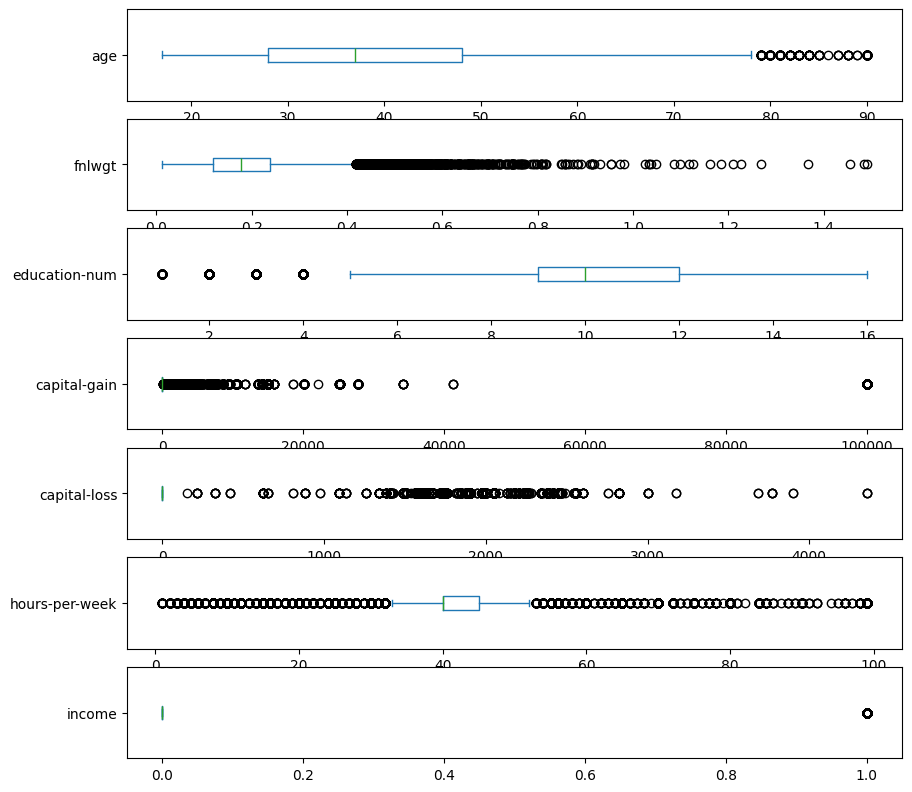

In [145]:
# Create box plot for each numerical column in Data Frame 
df.plot(kind='box', figsize=(10,14), layout=(10,1), sharex=False, subplots=True, vert=False);

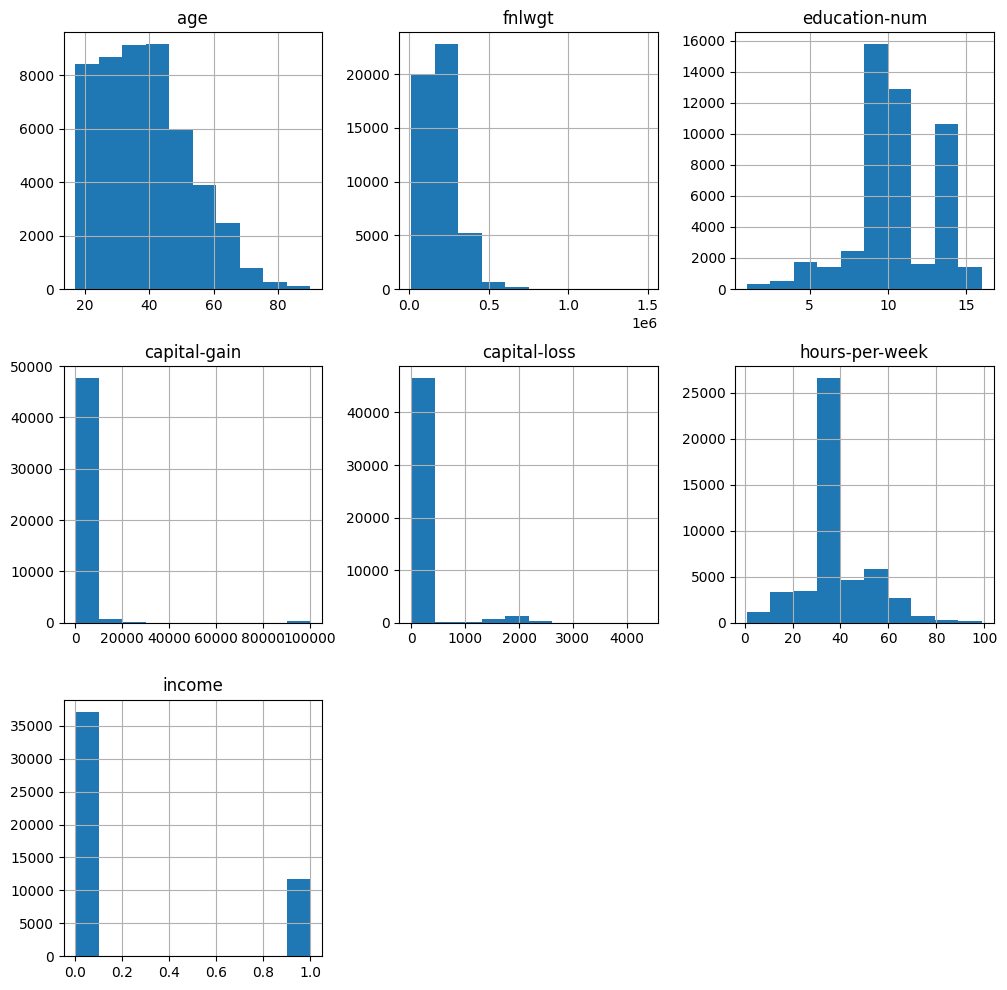

In [146]:
# Create histograms for each numerical column in Data Frame
df.hist(figsize=(12,12), layout=(3,3), sharex=False);

<Axes: >

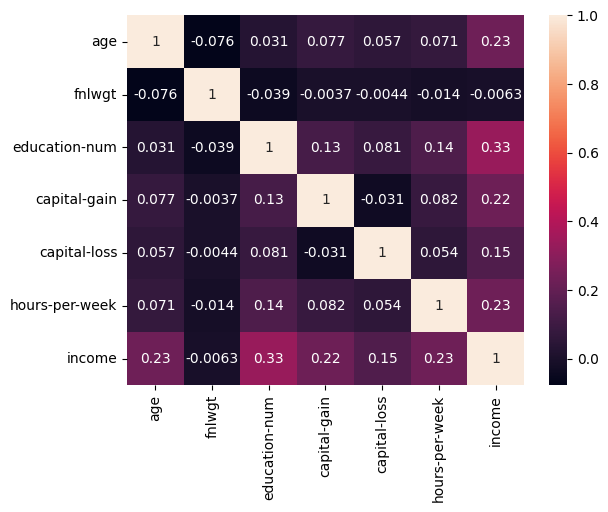

In [147]:
# Create a heatmap to visualize the correlation matrix of numeric columns in Data Frame
sns.heatmap(columns_numeric.corr(), annot = True)

In [148]:
# Create a pie chart
# px.pie(df,values='education-num', names='education', title='Percentages of education', color_discrete_sequence=px.colors.qualitative.Pastel)

### Encoding

#### Label Encoder

In [149]:
# Create an instance of Label Encoder
encoder = LabelEncoder()

In [150]:
# applied to each column of the Data Frame
encoded_df = df.apply(encoder.fit_transform)

##### Split dataset

In [151]:
# Split the dataset  in to 80% training and 20% testing 
X = encoded_df.drop('income', axis=1)  # Create a new Data Frame 'X' by dropping the 'income' column from the encoded_df
y = encoded_df['income']  # Assign the 'income' column to the variable 'y'

In [152]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)  # Splits data into 80% for training and 20% for testing. The parameter random_state=42 shows reproducibility.

##### SMOTE

In [153]:
# SMOTE Initializatoin
smote = SMOTE(random_state=42)

In [154]:
# Use SMOTE to the training data to avoid leakage of data 
train_X_balanced, train_y_balanced = smote.fit_resample(train_X, train_y)

## Random Forest Classifier

In [155]:
# Random Forest Classifier
classifier_RF = RandomForestClassifier(random_state=42)

In [156]:
classifier_RF.fit(train_X, train_y)  # Train the classifier on the training data

RandomForestClassifier(random_state=42)

In [157]:
# Predictions to the trained dataset
train_pred_RF = classifier_RF.predict(train_X)  # Generates predictions for the training dataset X
test_pred_RF = classifier_RF.predict(test_X)  # Generates predictions for the test dataset X

In [158]:
# Calculating accuracies
train_accuracy_RF = accuracy_score(train_y, train_pred_RF)  # Calculates the accuracy of the model on the training dataset y
test_accuracy_RF = accuracy_score(test_y, test_pred_RF)  # Calculates the accuracy of the model on the test dataset y

In [159]:
# Print the output
print("RandomForest Classifier - ")
print("Training Accuracy :", train_accuracy_RF)
print("Testing Accuracy :", test_accuracy_RF)

RandomForest Classifier - 
Training Accuracy : 0.9998718966974969
Testing Accuracy : 0.8489444558311129


In [160]:
# Random Forest Classifier with adjusted hyperparameters
classifier_RF = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=5, min_samples_leaf=2)  # Initialize Random Forest classifier with specified hyperparameters

In [161]:
classifier_RF.fit(train_X, train_y)  # Train the Random Forest classifier on the training data 

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [162]:
rain_pred_RF = classifier_RF.predict(train_X)  # Generate predictions for the training dataset
test_pred_RF = classifier_RF.predict(test_X)  # Generate predictions for the test dataset

In [163]:
# Calculating accuracies
train_accuracy_RF = accuracy_score(train_y, train_pred_RF)  # Calculates the accuracy of the model on the training dataset y
test_accuracy_RF = accuracy_score(test_y, test_pred_RF)  # Calculates the accuracy of the model on the test dataset y

In [164]:
# Print the output
print("RandomForest Classifier after handling the overfitting -")
print("Training Accuracy:", train_accuracy_RF)
print("Testing Accuracy:", test_accuracy_RF)

RandomForest Classifier after handling the overfitting -
Training Accuracy: 0.9998718966974969
Testing Accuracy: 0.860832137733142


## Naïve Bayes Classifier

In [165]:
# Naïve Bayes Classifier
classifier_NB = GaussianNB()

In [166]:
classifier_NB.fit(train_X, train_y) # Train the classifier on the training data

GaussianNB()

In [167]:
train_pred_NB = classifier_NB.predict(train_X)  # Generate predictions for the training dataset
test_pred_NB = classifier_NB.predict(test_X)  # Generate predictions for the test dataset

In [168]:
# Calculating accuracies
train_accuracy_NB = accuracy_score(train_y, train_pred_NB)  # Calculates the accuracy of the model on the training dataset y
test_accuracy_NB = accuracy_score(test_y, test_pred_NB)  # Calculates the accuracy of the model on the test dataset y

In [169]:
# Print the output
print("NaïveBayes Classifier -")
print("Training Accuracy:", train_accuracy_NB)
print("Testing Accuracy:", test_accuracy_NB)

NaïveBayes Classifier -
Training Accuracy: 0.8169660013835157
Testing Accuracy: 0.8084648493543759
